In [1]:
import os
import argparse
import torch
import numpy as np
import matplotlib.pyplot as plt
from torch import Tensor
from typing import *
from pathlib import Path
from netCDF4 import Dataset as NetCDFDataset
from sda.score import GaussianScore, DPSGaussianScore, MMPSGaussianScore, VPSDE, ScaledVPSDE, MCScoreNet, ScoreUNet
from utils import TrajectoryDataset, save_spectrum, save_video, OBS_FNS, ACTIVATIONS
import wandb
from metrics import rmse, crps_ens, spread_skill_ratio

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

Using device: cuda


In [2]:
class LocalScoreUNet(ScoreUNet):
    r"""Creates a score U-Net with a forcing channel."""

    def __init__(
        self,
        channels: int,
        size: int = 64,
        **kwargs,
    ):
        super().__init__(channels, 1, **kwargs)

        domain = 2 * torch.pi / size * (torch.arange(size) + 1 / 2)
        forcing = torch.sin(4 * domain).expand(1, size, size).clone()

        self.register_buffer('forcing', forcing)

    def forward(self, x: Tensor, t: Tensor, c: Tensor = None) -> Tensor:
        return super().forward(x, t, self.forcing)

def make_score(
    window: int,
    embedding: int,
    hidden_channels: Tuple[int],
    hidden_blocks: Tuple[int],
    kernel_size: int,
    activation: str,
    **absorb
) -> torch.nn.Module:
    
    score = MCScoreNet(2, order=window // 2)

    score.kernel = LocalScoreUNet(
        channels=window * 2,
        embedding=embedding,
        hidden_channels=hidden_channels,
        hidden_blocks=hidden_blocks,
        kernel_size=kernel_size,
        activation=ACTIVATIONS[activation],
        spatial=2,
        padding_mode='circular',
    )
    return score

In [3]:
from types import SimpleNamespace

def make_args(**overrides):
    defaults = dict(
        # Data
        data_dir="/central/scratch/sotakao/sqg_train_data",
        train_file="sqg_pv_train.h5",
        hrly_freq=3,

        # Model
        window=5,
        embedding=64,
        hidden_channels=[96, 192, 384],
        hidden_blocks=[3, 3, 3],
        kernel_size=3,
        activation="SiLU",
        epochs=4096,
        batch_size=32,
        learning_rate=2e-4,
        weight_decay=1e-3,

        # Obs + Guidance
        obs_type="random",          # {"grid","random"}
        obs_stride=4,
        obs_pct=0.25,
        obs_fn="linear",            # {"linear","arctan15"}
        obs_sigma=0.3,
        fixed_obs=False,
        n_ens=20,
        guidance_method="DPS",      # {"DPS"}
        gamma=1e-2,
        steps=100,
        corrections=1,
        tau=0.5,

        # Output / Logging
        output_dir="./output",
        log_wandb=1,                # keep as int for parity; cast to bool below
        wandb_project="ScoreDA_SQG",
        wandb_entity="stima",
    )
    defaults.update(overrides)
    ns = SimpleNamespace(**defaults)
    ns.log_wandb = bool(ns.log_wandb)  # mimic your CLI cast
    return ns

# Example usage (override anything you like):
args = make_args()


In [4]:
args.corrections

1

In [5]:
pv_mean = torch.as_tensor(0.0, device=device, dtype=torch.float32)
pv_std = torch.as_tensor(2672.232, device=device, dtype=torch.float32)
obs_fn = OBS_FNS[args.obs_fn]
rng = np.random.RandomState(42)

# Load pv_truth from NetCDF (test file)
test_file = Path(args.data_dir) / f"{args.hrly_freq}hrly" / f"sqg_N64_{args.hrly_freq}hrly_100.nc"
nc_truth = NetCDFDataset(test_file, 'r')
pv_truth_nc = nc_truth.variables['pv']  # expected shape: (T, 2, ny, nx)
T, Z, ny, nx = pv_truth_nc.shape

# Slice window and move to torch
pv_truth = torch.tensor(np.array(pv_truth_nc[:T, ...]), dtype=torch.float32, device=device)  # (T, 2, ny, nx)
scalefact = nc_truth.f*nc_truth.theta0/nc_truth.g # 0.003061224412462883

# Optional: close file handle after reading metadata and pv
nc_truth.close()


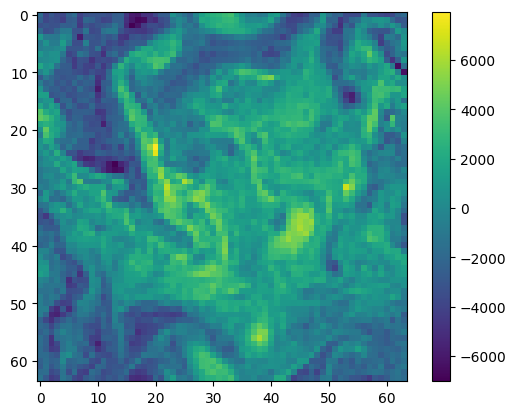

In [6]:
plt.imshow(pv_truth[0,0].cpu().numpy())
plt.colorbar()

In [7]:
# Build observation mask
def make_obs_mask(ny_, nx_):
    if args.obs_type == "grid":
        stride = args.obs_stride
        mask = torch.zeros(ny_, nx_, device=device)
        mask[::stride, ::stride] = 1.0
    elif args.obs_type == "random":
        nobs = int(ny_ * nx_ * args.obs_pct)
        idx = rng.choice(ny_ * nx_, nobs, replace=False)
        mask = torch.zeros(ny_ * nx_, device=device)
        mask[torch.from_numpy(idx).to(device)] = 1.0
        mask = mask.view(ny_, nx_)
    else:
        raise NotImplementedError("Unsupported observation type.")
    return mask  # (ny, nx)

obs_mask = make_obs_mask(ny, nx)  # (ny, nx)

In [8]:
# Load checkpointed score/SDE
ckpt_dir = Path("../../runs_sqg") / f"mcscore_vpsde_sqg_window_{args.window}" / "checkpoints"
files = sorted(ckpt_dir.glob("epoch_*.pt"))
if not files:
    raise FileNotFoundError(f"No checkpoint files found in {ckpt_dir}.")
payload = torch.load(files[-1], map_location=device)

CONFIG = {
    'window': args.window,
    'embedding': args.embedding,
    'hidden_channels': tuple(args.hidden_channels),
    'hidden_blocks': tuple(args.hidden_blocks),
    'kernel_size': args.kernel_size,
    'activation': args.activation,
    'epochs': args.epochs,
    'batch_size': args.batch_size,
    'learning_rate': args.learning_rate,
    'weight_decay': args.weight_decay,
}

# Build model and SDE
score_obj = make_score(**CONFIG)
score_obj.load_state_dict(payload["score_state"])
score_obj = score_obj.to(device).eval()

In [9]:
# Observation operator: normalized model state -> physical -> obs space, masked
# def A_model(x):
#     # x_norm: (T, 2, ny, nx)
#     # x_phys = x_norm * pv_std + pv_mean
#     return obs_fn(x) * obs_mask  # broadcast on (ny, nx)

def A_model(x):
    return obs_fn(x[..., obs_mask.bool()])

# Create observations from scaled pv_truth with noise (only at observed points)
# noise = torch.randn_like(pv_truth) * args.obs_sigma
# y_star = obs_fn(scalefact * pv_truth) * obs_mask + noise * obs_mask  # (T, 2, ny, nx)

y_star = A_model(scalefact * pv_truth)
noise = torch.randn_like(y_star) * args.obs_sigma
y_star += noise

In [10]:
# plt.imshow(y_star[0,0].detach().cpu().numpy())
# plt.colorbar()

In [18]:
scale = (scalefact * pv_std).to(device)
score_scaled = lambda x, t, c: score_obj(x/scale, t, c)
guided_sde = ScaledVPSDE(
          DPSGaussianScore(y_star,
                        A=A_model,
                        std=args.obs_sigma,
                        sde=ScaledVPSDE(score_scaled, shape=(), scale=scale),
                        gamma=args.gamma,
                        guidance_strength=0.01,
                        scale=True,
                        ),
    scale=scale,
    shape=pv_truth.shape,
).to(device)

# guided_sde = ScaledVPSDE(
#           MMPSGaussianScore(y_star,
#                             observation_fn=A_model,
#                             std=args.obs_sigma,
#                             sde=ScaledVPSDE(score_scaled, shape=(), scale=scale),
#                             ),
#     scale=scale,
#     shape=pv_truth.shape,
# ).to(device)

In [19]:
sample = guided_sde.sample((1,),
                           steps=args.steps,
                           # corrections=args.corrections,
                           corrections=1,
                           tau=args.tau)  # (1, T, 2, ny, nx)

100%|█████████████████████████████████████████████████| 100/100 [03:22<00:00,  2.02s/it]


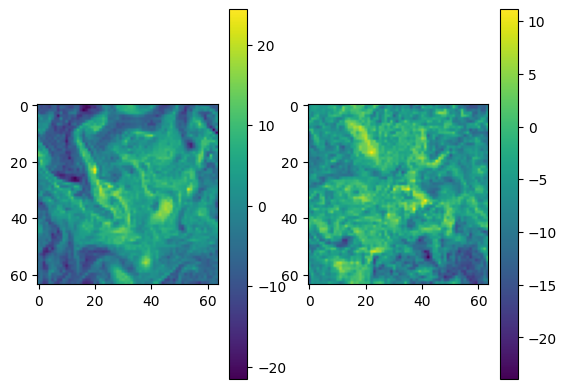

In [20]:
fig, axs = plt.subplots(1, 2)
im0 = axs[0].imshow(scalefact * pv_truth[0,0].cpu().numpy())
plt.colorbar(im0)
im1 = axs[1].imshow(sample[0,0,0].detach().cpu().numpy())
plt.colorbar(im1)

In [14]:
sample.max()

tensor(28.8347, device='cuda:0')